# Loading dependencies and model

In [305]:
import os
import torch
from torchvision import datasets, transforms
from utils import loaders_by_classes, filter_loaders, balance
from classNet import ConvNet, submodel # for torch load
import matplotlib.pyplot as plt

In [306]:
_model = torch.load('./models/all_class.pth', weights_only=False)
_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
num_workers = os.cpu_count()
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [308]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# Choose class to Test

In [367]:
class_num = 7
class_name = '7 - seven'
class_loader = test_loaders[class_name]


In [310]:
bal = balance(test_loaders)
n_items_class = bal[class_name]
n_tot = 0
for key, val in bal.items():
    if key != class_name:
        n_tot += val
proportion = n_items_class / n_tot
balanced_batch_size = (1 - proportion) * batch_size / proportion

In [311]:
filtered_loader = filter_loaders(test_loaders, class_name, balanced_batch_size, shuffle=True, num_workers=num_workers)

# Submodel

In [ ]:
model = submodel(_model, class_num)
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

# Get Activations Residues

In [ ]:
def get_activations(model, input_tensor, layer_num, verbose=True):
    """
    Get the internal representation of input tensor at after the layer 'layer_num'
    """

    if layer_num == 0:
        return model(input_tensor)
    
    layers = list(model.children())
    layer = layers[layer_num]

    if verbose:
        print(f'Checking residues of the input after layer : {layer}')

    # Variable pour stocker les activations
    activations = None

    # Hook pour capturer les activations
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output

    handle = layer.register_forward_hook(hook_fn)
    output = model(input_tensor)
    handle.remove()

    return activations

In [368]:
class Special_Loss():
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        self.values = None
        self.target = None
    
    def __call__(self):
        return self.criterion(self.values, self.target)

In [ ]:
def get_grad(model, input, layer_num, special_loss):
    

# Gradients pour classic Loss 

tensor(4)


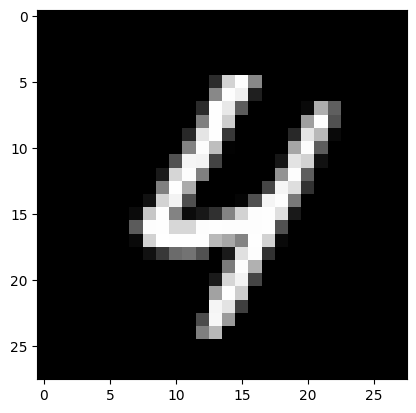

In [351]:
input = next(iter(filtered_loader))
plt.imshow(input[0][0].squeeze(), cmap='gray')
print(input[1][0])

In [352]:
def get_param_grad_1(model, input, back_lay_num = 1):
    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # Calcul de la perte et rétropropagation
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label_tensor)
    loss.backward()

    # Récupérer le gradient des poids et biais du layer paramétrique
    layer = list(model.children())[- back_lay_num]  # Dernier layer du modèle

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    return grad_params

In [370]:
model.parameters()

<generator object Module.parameters at 0x3699fde00>

In [353]:
input_tensor, label_tensor = input
input_tensor = input_tensor.to(device)
label_tensor = label_tensor.to(device)

# Assurez-vous que l'entrée a bien requires_grad activé
input_tensor.requires_grad_(True)

# Passer en avant jusqu'au dernier layer paramétrique
model.zero_grad()
output = model(input_tensor)

# Calcul de la perte et rétropropagation
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(output, label_tensor - 1)
loss

tensor(12.9058, device='mps:0', grad_fn=<NllLossBackward0>)

In [354]:
input[1]

tensor([4, 8, 6, 8, 9, 5, 8, 9, 1, 6, 6, 9, 9, 5, 6, 2, 2, 6, 9, 5, 4, 4, 1, 3,
        0, 4, 3, 0, 5, 5, 5, 0, 4, 3, 5, 3, 9, 0, 8, 3, 9, 2, 3, 6, 6, 9, 5, 1,
        1, 5, 0, 5, 5, 0, 9, 6, 0, 4, 0, 3, 8, 4, 2, 9])

In [355]:
grad_1 = get_param_grad_1(model, input)

In [356]:
grad_1

[tensor([ 1.3633e-04,  6.9456e-04,  1.1545e-04,  ..., -7.0408e-01,
          7.4758e-05,  0.0000e+00], device='mps:0'),
 tensor([ 4.0399e-04,  2.5027e-03, -2.5625e-03,  7.0209e-04,  4.5496e-06,
          1.6469e-03, -3.0988e-03,  7.8508e-02, -7.8107e-02], device='mps:0')]

# Gradient pour Target Loss

tensor(7)


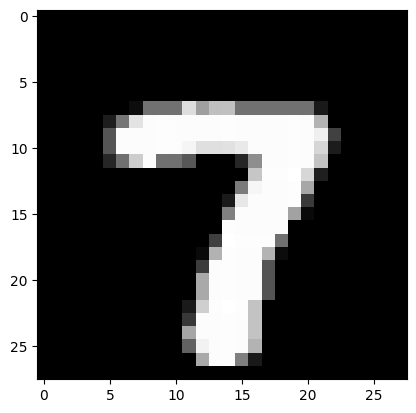

In [350]:
input = next(iter(class_loader))
# plot un example d'image input
plt.imshow(input[0][0].squeeze(), cmap='gray')
print(input[1][0])

In [321]:
_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [322]:
torch.exp(model(input[0].to(device))[:,:7])

tensor([[1.7220e-04, 2.7673e-06, 2.5021e-01, 4.4256e-01, 4.2502e-05, 1.0672e-07,
         1.1480e-10],
        [9.7688e-08, 1.4775e-01, 9.1244e-04, 2.9768e-02, 7.0895e-04, 4.7622e-07,
         5.9380e-11],
        [1.1069e-07, 1.1872e-03, 6.3919e-04, 4.5771e-04, 2.9711e-04, 9.5426e-10,
         5.8935e-12],
        [3.1139e-08, 9.6543e-01, 6.5031e-03, 1.4358e-03, 4.2161e-03, 4.2981e-08,
         1.0652e-10],
        [1.8275e-05, 6.5613e-01, 3.0632e-02, 3.1141e-01, 1.0360e-06, 1.4288e-06,
         5.9626e-10],
        [6.8795e-11, 1.0833e-02, 9.1176e-02, 8.8077e-01, 1.3557e-02, 6.4685e-07,
         1.5730e-10],
        [1.3713e-08, 5.2464e-02, 3.6141e-01, 1.2693e-02, 4.5610e-03, 4.2800e-09,
         4.4250e-12],
        [9.5057e-05, 3.0581e-05, 3.4534e-04, 7.1609e-06, 3.8460e-10, 4.9535e-04,
         6.6138e-08],
        [7.7700e-05, 2.6831e-03, 1.8838e-05, 1.3546e-03, 4.6315e-03, 3.3174e-04,
         1.0484e-07],
        [1.3681e-05, 7.6765e-04, 2.2286e-04, 7.5453e-01, 6.5308e-04, 2.20

In [323]:
base_output = _model(input[0].to(device))
trun_output = model(input[0].to(device))

subbase_output = torch.cat([base_output[:,:7], base_output[:,7+1:]], dim=1)

go_exp_base = torch.exp(subbase_output)
go_exp_trun = torch.exp(trun_output)

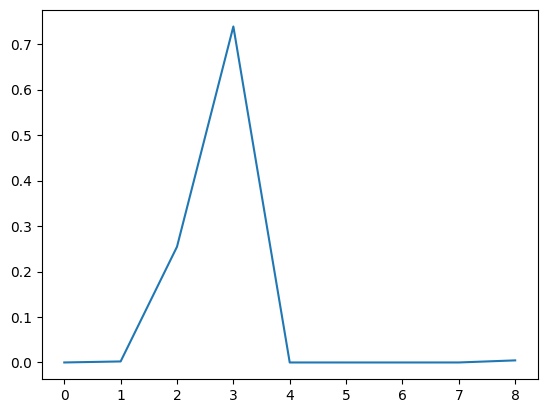

In [324]:
plt.plot(go_exp_trun.detach().cpu().numpy()[0])

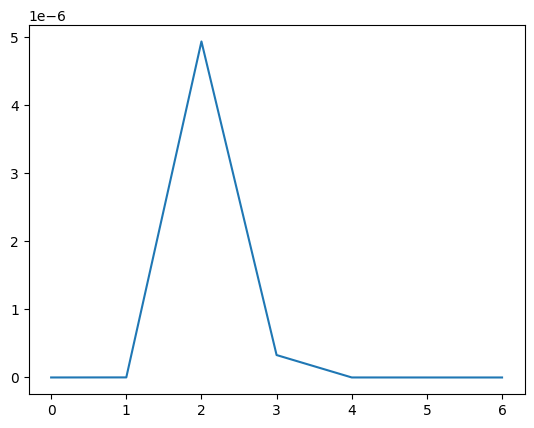

In [325]:
output_logits = torch.exp(_model(input[0].to(device))[:, :7])
plt.plot(output_logits.detach().cpu().numpy()[0])

In [326]:
def get_param_grad_2(model, input, back_lay_num = 1):
    input_tensor, label_tensor = input
    input_tensor = input_tensor.to(device)
    label_tensor = label_tensor.to(device)

    # Assurez-vous que l'entrée a bien requires_grad activé
    input_tensor.requires_grad_(True)

    # Cible : couche à surveiller
    layers = list(model.children())
    layer = layers[-back_lay_num]

    # Variable pour stocker les activations
    activations = None

    # Hook pour capturer les activations
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output

    # Enregistrement du hook
    layer.register_forward_hook(hook_fn)
    
    # Passer en avant jusqu'au dernier layer paramétrique
    model.zero_grad()
    output = model(input_tensor)

    # activation correspond à la sortie de la couche AVANT log_softmax 
    _activations = activations.detach()
    # print(activations)
    # print(torch.mean(_activations, dim=0, keepdim=True))
    a0 = torch.mean(_activations, dim=0)
    ma0 = torch.mean(_activations)
    va0 = torch.var(_activations)
    print(ma0, va0)
    target = _activations - (1 - torch.nn.functional.softmax(_activations, dim=0)) * a0
    # target = - torch.ones(9).to(device)
    print(torch.mean(target), torch.var(target))

    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(activations, target)
    loss.backward()

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    return grad_params

In [349]:
model.eval()
grad_2 = get_param_grad_2(model, input)

tensor(-5.0368, device='mps:0') tensor(42.3698, device='mps:0')
tensor(-0.0787, device='mps:0') tensor(10.8319, device='mps:0')


In [ ]:
def get_param_grad_2(model, input, layer_num = -1):
    layers = list(model.children())
    layer = layers[-layer_num]

    activations = get_activations(model, input, layer_num, requires_grad=True)
    
    _activations = activations.detach()
    # print(activations)
    # print(torch.mean(_activations, dim=0, keepdim=True))
    a0 = torch.mean(_activations, dim=0)
    ma0 = torch.mean(_activations)
    va0 = torch.var(_activations)
    print(ma0, va0)
    target = _activations - (1 - torch.nn.functional.softmax(_activations, dim=0)) * a0
    # target = - torch.ones(9).to(device)
    print(torch.mean(target), torch.var(target))

    # Calcul de la perte et rétropropagation
    loss = torch.nn.functional.mse_loss(activations, target)
    loss.backward()

    # Liste pour stocker les gradients de chaque paramètre
    grad_params = []

    for param in layer.parameters():
        # Aplatir les gradients des paramètres (poids et biais)
        grad_params.append(param.grad.flatten())  # Aplatir les gradients des poids et biais

    return grad_params

In [348]:
model.eval()
grad_2 = get_param_grad_2(model, input)

tensor(-5.0368, device='mps:0') tensor(42.3698, device='mps:0')
tensor(-0.0787, device='mps:0') tensor(10.8319, device='mps:0')


In [328]:
no_seven = submodel(torch.load('models/no_7 - seven.pth'), 7).to(device)
no_seven.eval()
gn = get_param_grad_2(no_seven, input)

tensor(-0.8377, device='mps:0') tensor(32.5010, device='mps:0')
tensor(-0.0131, device='mps:0') tensor(8.6286, device='mps:0')


/var/folders/17/d5wm_d6x5zv68h4w18r3246h4xmqkj/T/ipykernel_5869/2570209511.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  no_seven = submodel(torch.load('models/no_7 - 

In [329]:
grad_2[0].size()

torch.Size([1152])

In [330]:
gn[0]- grad_2[0]

tensor([-0.3474,  0.0000, 17.1188,  ...,  0.0449,  0.0000,  3.2639],
       device='mps:0')

In [366]:
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [365]:
get_activations(model, input[0].to(device), -3).size()

Checking residues of the input after layer : Dropout2d(p=0.25, inplace=False)


torch.Size([64, 64, 14, 14])

# Calcul Masking

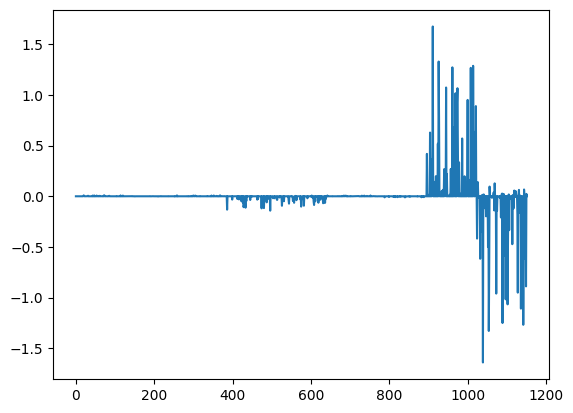

In [331]:
plt.plot(grad_1[0].detach().cpu().numpy())

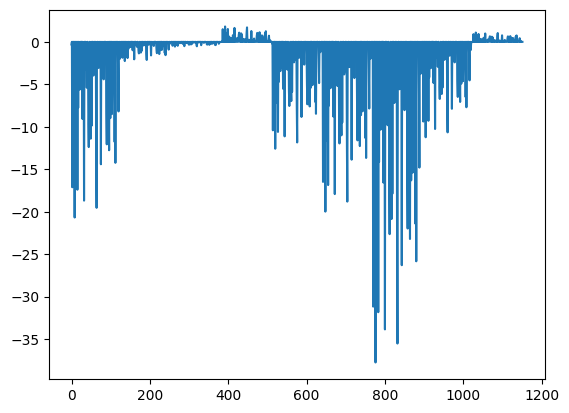

In [332]:
plt.plot(grad_2[0].detach().cpu().numpy())

In [333]:
mask = [(grad_1[0] * grad_2[0])> 0, (grad_1[1] * grad_2[1]) > 0]
torch.sum(mask[0]) + torch.sum(mask[1])

tensor(197, device='mps:0')

In [334]:
mask[0]*grad_2[0]*torch.abs(grad_1[0])

tensor([-0., 0., -0.,  ..., 0., 0., 0.], device='mps:0')

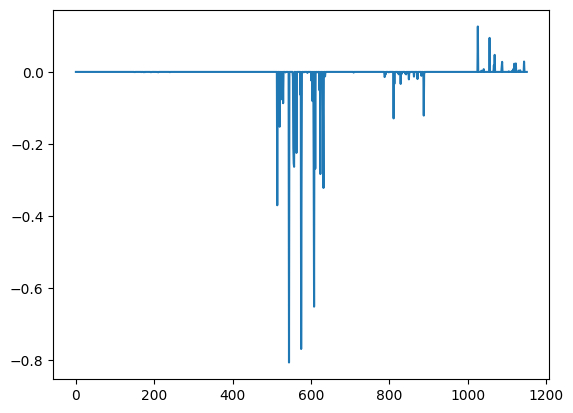

In [335]:
new_grad = [grad_2[0] * torch.abs(grad_1[0]) * mask[0], grad_2[1] * torch.abs(grad_1[1]) * mask[1]]
plt.plot(new_grad[0].detach().cpu().numpy())

In [336]:
back_lay_num = 1
layer = list(model.children())[- back_lay_num]
params = layer.parameters()
list_params = list(params)
list_params[0].grad = 3000 * list_params[0].grad 
list_params[0].grad = 

SyntaxError: invalid syntax (2832114561.py, line 6)

In [ ]:
wgt, bias = list_params[0], list_params[1]
wgt, bias

(Parameter containing:
 tensor([[-0.1386,  0.1189, -0.1357,  ...,  0.0622,  0.0444, -0.0596],
         [ 0.0602,  0.0746,  0.0614,  ...,  0.0468, -0.1018, -0.0262],
         [-0.2365,  0.0751,  0.0738,  ...,  0.0325,  0.0142, -0.0390],
         ...,
         [-0.1448, -0.1523,  0.0451,  ..., -0.1763, -0.0253, -0.0100],
         [ 0.0359, -0.0877, -0.0979,  ...,  0.1001, -0.1611,  0.0632],
         [ 0.0805,  0.0698,  0.0568,  ..., -0.1275,  0.0459,  0.0399]],
        device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0903,  0.0220, -0.0523,  0.0591,  0.0151, -0.0137,  0.0476, -0.0684,
          0.0690, -0.0051], device='mps:0', requires_grad=True))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)